# 2. Cluster and Trend Analysis

### 2.1 Standard function to call and filter an entire subreddit history

In [7]:
import zstandard
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from datetime import datetime
from textblob import TextBlob

# Set up logging
log = logging.getLogger("reddit_analysis")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


# Function to decode zstandard files
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


# Function to read lines from a zst file
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")
            for line in lines[:-1]:
                yield line, file_handle.tell()
            buffer = lines[-1]
        reader.close()


# Function to process the raw file into a DataFrame
def load_reddit_data(file_path):
    log.info(f"Loading data from: {file_path}")
    file_size = os.stat(file_path).st_size
    data = []
    bad_lines = 0
    for line, _ in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))
            data.append(obj)
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
    log.info(f"Data loading complete with {len(data):,} rows and {bad_lines:,} bad lines.")
    return pd.DataFrame(data)


# Function to filter and process the DataFrame
def filter_data(df, min_chars, keywords=None, start_year=None, end_year=None):
    log.info("Filtering data...")
    
    # Filter columns
    columns_to_keep = [
        "title", "selftext", "score", "archived", "author",
        "created_utc", "id", "media", "num_comments",
        "subreddit", "created_datetime"
    ]
    df = df[columns_to_keep]
    
    # Filter by text length
    df = df[df['selftext'].str.len() > min_chars]
    
    # Filter by keywords
    if keywords:
        keyword_regex = '|'.join([rf'\b{k}\b' for k in keywords])
        df = df[df['selftext'].str.contains(keyword_regex, flags=re.IGNORECASE, na=False)]
    
    # Filter by year range
    df['year'] = df['created_datetime'].dt.year
    if start_year:
        df = df[df['year'] >= start_year]
    if end_year:
        df = df[df['year'] <= end_year]
    
    log.info(f"Filtered data to {len(df):,} rows.")
    return df


# Function to plot the number of posts per year
def plot_posts_per_year(df):
    posts_per_year = df['year'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')
    plt.title('Number of Posts per Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Posts', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Main pipeline function
def analyze_reddit_data(file_path, min_chars, keywords=None, start_year=None, end_year=None):
    log.info("Starting Reddit Data Analysis...")
    
    # Step 1: Load data
    df = load_reddit_data(file_path)
    
    # Step 2: Filter data
    filtered_df = filter_data(df, min_chars, keywords, start_year, end_year)
    
    # Step 3: Plot data
    plot_posts_per_year(filtered_df)
    
    return filtered_df

### 2.2 Simple sentiment analysis pipeline (without comments)

In [8]:
def analyze_sentiment(text):
    """
    Analyzes the sentiment of a given text using TextBlob.
    Returns Positive, Negative, or Neutral based on polarity.
    """
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

def assign_sentiments(df):
    """
    Assign sentiment labels to the posts in the DataFrame.
    """
    df['sentiment'] = df['selftext'].apply(analyze_sentiment)
    return df

def calculate_sentiment_distribution(df):
    """
    Groups posts by year and sentiment and calculates sentiment percentages per year.
    """
    # Extract year
    df['year'] = df['created_datetime'].dt.year
    
    # Count posts per sentiment per year
    sentiment_counts = df.groupby(['year', 'sentiment']).size().reset_index(name='count')
    
    # Total posts per year
    total_per_year = df.groupby('year').size().reset_index(name='total')
    
    # Merge counts with totals
    sentiment_distribution = pd.merge(sentiment_counts, total_per_year, on='year')
    
    # Calculate percentage
    sentiment_distribution['percentage'] = (
        sentiment_distribution['count'] / sentiment_distribution['total'] * 100
    )
    
    return sentiment_distribution

def plot_sentiment_distribution(sentiment_distribution):
    """
    Plots the sentiment distribution over time.
    """
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=sentiment_distribution,
        x='year', y='percentage', hue='sentiment', marker='o'
    )
    plt.title('Sentiment Distribution Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Percentage of Posts', fontsize=14)
    plt.legend(title='Sentiment', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def sentiment_analysis_pipeline(submissions_df):
    """
    Full pipeline to analyze sentiment and plot distribution over time.
    """
    # Step 1: Assign sentiment to posts
    submissions_with_sentiment = assign_sentiments(submissions_df)
    
    # Step 2: Calculate sentiment distribution
    sentiment_distribution = calculate_sentiment_distribution(submissions_with_sentiment)
    
    # Step 3: Plot the sentiment distribution
    plot_sentiment_distribution(sentiment_distribution)

    return submissions_with_sentiment, sentiment_distribution


### 2.3 Use Case 2: Cluster of meaningful topics (on all posts) & Highlight of new trends/spikes of interest

In [9]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


def preprocess_text(text: str) -> str:
    """
    Preprocesses the given text by lowercasing, removing special characters, 
    tokenizing, removing stopwords, and lemmatizing.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: Preprocessed text.
    """
    # Lowercase the text
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


def perform_lda(
    text_data: pd.Series, 
    n_topics: int = 5, 
    max_features: int = 5000
) -> Tuple[LatentDirichletAllocation, CountVectorizer, np.ndarray]:
    """
    Performs LDA topic modeling on the provided text data.

    Args:
        text_data (pd.Series): A pandas Series of text data to analyze.
        n_topics (int): Number of topics to generate.
        max_features (int): Maximum number of features for vectorization.

    Returns:
        Tuple: LDA model, CountVectorizer, and topic assignments.
    """
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    text_matrix = vectorizer.fit_transform(text_data)

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(text_matrix)

    return lda, vectorizer, lda.transform(text_matrix)


def display_topics(lda: LatentDirichletAllocation, feature_names: List[str], n_top_words: int = 10) -> Dict[str, List[str]]:
    """
    Extracts and displays the top words for each topic from the LDA model.

    Args:
        lda (LatentDirichletAllocation): Fitted LDA model.
        feature_names (List[str]): List of feature names from vectorization.
        n_top_words (int): Number of words to display for each topic.

    Returns:
        Dict[str, List[str]]: A dictionary of topics and their top words.
    """
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        topics[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics


def analyze_topics_over_time(
    df: pd.DataFrame, 
    topic_assignments: np.ndarray
) -> pd.DataFrame:
    """
    Analyzes topic trends over time by calculating the number of posts per topic per year.

    Args:
        df (pd.DataFrame): DataFrame containing the original data with a 'created_datetime' column.
        topic_assignments (np.ndarray): Topic assignments for each post.

    Returns:
        pd.DataFrame: Topic trends over time.
    """
    df['dominant_topic'] = topic_assignments.argmax(axis=1) + 1  # Add 1 for 1-based indexing
    df['year'] = df['created_datetime'].dt.year

    # Count posts per topic per year
    topic_trends = df.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

    return topic_trends


def detect_spikes(
    topic_trends: pd.DataFrame, 
    overall_trends: pd.Series
) -> pd.DataFrame:
    """
    Detects spikes in topic popularity relative to the overall number of posts.

    Args:
        topic_trends (pd.DataFrame): Trends of topics over time.
        overall_trends (pd.Series): Overall number of posts per year.

    Returns:
        pd.DataFrame: DataFrame of percentage changes (spikes).
    """
    # Normalize by overall number of posts
    normalized_trends = topic_trends.div(overall_trends, axis=0).fillna(0)
    percentage_change = normalized_trends.pct_change().fillna(0)

    # Highlight spikes (e.g., >50% growth)
    return percentage_change[percentage_change > 0.5]


def plot_trends(topic_trends: pd.DataFrame) -> None:
    """
    Plots topic trends over time.

    Args:
        topic_trends (pd.DataFrame): Trends of topics over time.
    """
    plt.figure(figsize=(12, 6))
    topic_trends.plot(kind='line', marker='o', colormap='tab10', figsize=(12, 6))
    plt.title('Topic Trends Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Posts', fontsize=14)
    plt.legend(title='Topics', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_spikes(spikes: pd.DataFrame) -> None:
    """
    Plots a heatmap of spikes in topic popularity.

    Args:
        spikes (pd.DataFrame): DataFrame of percentage changes (spikes).
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(spikes, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Spikes in Topic Popularity (Percentage Change)", fontsize=16)
    plt.xlabel("Topic", fontsize=14)
    plt.ylabel("Year", fontsize=14)
    plt.tight_layout()
    plt.show()

def get_cluster_descriptions(
    df: pd.DataFrame, 
    lda: LatentDirichletAllocation, 
    vectorizer: CountVectorizer, 
    n_top_words: int = 10, 
    n_examples: int = 3
) -> Dict[str, Dict[str, List[str]]]:
    """
    Creates meaningful descriptions for each cluster based on top words and example posts.

    Args:
        df (pd.DataFrame): The input DataFrame with posts.
        lda (LatentDirichletAllocation): Fitted LDA model.
        vectorizer (CountVectorizer): Fitted CountVectorizer.
        n_top_words (int): Number of top words to include in the description.
        n_examples (int): Number of example posts to include for each topic.

    Returns:
        Dict[str, Dict[str, List[str]]]: Dictionary containing top words and examples for each topic.
    """
    feature_names = vectorizer.get_feature_names_out()
    cluster_descriptions = {}

    for topic_idx, topic in enumerate(lda.components_):
        # Get top words
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        
        # Get example posts
        topic_posts = df[df['dominant_topic'] == topic_idx + 1]  # 1-based indexing for topics
        example_posts = topic_posts['selftext'].head(n_examples).tolist()
        
        cluster_descriptions[f"Topic {topic_idx + 1}"] = {
            "Top Words": top_words,
            "Example Posts": example_posts
        }
    
    return cluster_descriptions


def get_trending_topic(
    df: pd.DataFrame, 
    lda: LatentDirichletAllocation, 
    vectorizer: CountVectorizer, 
    year: int, 
    month: int
) -> Tuple[int, List[str]]:
    """
    Identifies the trending topic for a specific month and year.

    Args:
        df (pd.DataFrame): The input DataFrame with posts.
        lda (LatentDirichletAllocation): Fitted LDA model.
        vectorizer (CountVectorizer): Fitted CountVectorizer.
        year (int): The year to filter by.
        month (int): The month to filter by.

    Returns:
        Tuple[int, List[str]]: Trending topic index and its top words.
    """
    feature_names = vectorizer.get_feature_names_out()

    # Filter posts by the specified month and year
    monthly_posts = df[(df['created_datetime'].dt.year == year) & 
                       (df['created_datetime'].dt.month == month)]
    
    if monthly_posts.empty:
        return None, ["No data available for this period."]
    
    # Count the number of posts for each topic
    topic_counts = monthly_posts['dominant_topic'].value_counts()

    # Get the most popular topic
    trending_topic = topic_counts.idxmax()

    # Get the top words for the trending topic
    top_words = [
        feature_names[i] 
        for i in lda.components_[trending_topic - 1].argsort()[:-11:-1]  # Adjust for 1-based indexing
    ]
    
    return trending_topic, top_words


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakobkuemmerle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jakobkuemmerle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jakobkuemmerle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def topic_modeling_pipeline(
    df: pd.DataFrame, 
    n_topics: int = 5, 
    max_features: int = 5000, 
    n_top_words: int = 10, 
    n_examples: int = 3
) -> None:
    """
    Executes the entire pipeline: preprocessing, topic modeling, trend analysis, and visualization.

    Args:
        df (pd.DataFrame): The input DataFrame with posts.
        n_topics (int): Number of topics for LDA.
        max_features (int): Maximum features for vectorization.
        n_top_words (int): Number of top words to display per topic.
        n_examples (int): Number of example posts to display for each topic.
    """
    # Preprocess text
    df['cleaned_text'] = df['selftext'].apply(preprocess_text)

    # Perform LDA
    lda, vectorizer, topic_assignments = perform_lda(df['cleaned_text'], n_topics, max_features)
    
    # Add topic assignments to DataFrame
    df['dominant_topic'] = topic_assignments.argmax(axis=1) + 1  # 1-based indexing
    
    # Display topics
    topics = display_topics(lda, vectorizer.get_feature_names_out(), n_top_words)
    print("Identified Topics:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")
    
    # Get cluster descriptions
    cluster_descriptions = get_cluster_descriptions(df, lda, vectorizer, n_top_words, n_examples)
    print("\nCluster Descriptions:")
    for topic, details in cluster_descriptions.items():
        print(f"{topic} - Top Words: {', '.join(details['Top Words'])}")
        for idx, example in enumerate(details['Example Posts']):
            print(f"Example {idx + 1}: {example[:200]}...")  # Print first 200 chars for readability

    # Analyze trends over time
    topic_trends = analyze_topics_over_time(df, topic_assignments)

    # Plot topic trends
    plot_trends(topic_trends)

    # Detect and plot spikes
    overall_trends = df.groupby('year').size()
    spikes = detect_spikes(topic_trends, overall_trends)
    print("Detected Spikes in Topics:")
    print(spikes)
    plot_spikes(spikes)


In [11]:
def trending_topic_pipeline(
    df: pd.DataFrame, 
    year: int, 
    month: int, 
    n_topics: int = 5, 
    max_features: int = 5000
) -> None:
    """
    Standalone pipeline to get the trending topic for a specific month and year.

    Args:
        df (pd.DataFrame): The input DataFrame with posts.
        year (int): The year to filter by.
        month (int): The month to filter by.
        n_topics (int): Number of topics for LDA model.
        max_features (int): Maximum number of features for the vectorizer.
    """
    # Vectorize the cleaned text data
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    text_data = df['cleaned_text'].values
    data_vectorized = vectorizer.fit_transform(text_data)

    # Train LDA model on the entire data
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(data_vectorized)

    # Get topic distributions for the posts
    topic_distribution = lda.transform(data_vectorized)

    # Assign the most likely topic to each post
    df['dominant_topic'] = topic_distribution.argmax(axis=1)

    # Call `get_trending_topic` for the specified month and year
    trending_topic, top_words = get_trending_topic(df, lda, vectorizer, year, month)

    if trending_topic is not None:
        print(f"Trending Topic for {year}-{month:02d}: Topic {trending_topic}")
        print(f"Top words for Topic {trending_topic}: {', '.join(top_words)}")
    else:
        print(f"No data available for {year}-{month:02d}.")


Starting Reddit Data Analysis...
Starting Reddit Data Analysis...
Loading data from: ../downloads/reddit-downloads/Northwestern_submissions.zst
Loading data from: ../downloads/reddit-downloads/Northwestern_submissions.zst
Data loading complete with 15,175 rows and 0 bad lines.
Data loading complete with 15,175 rows and 0 bad lines.
Filtering data...
Filtering data...
Filtered data to 2,488 rows.
Filtered data to 2,488 rows.


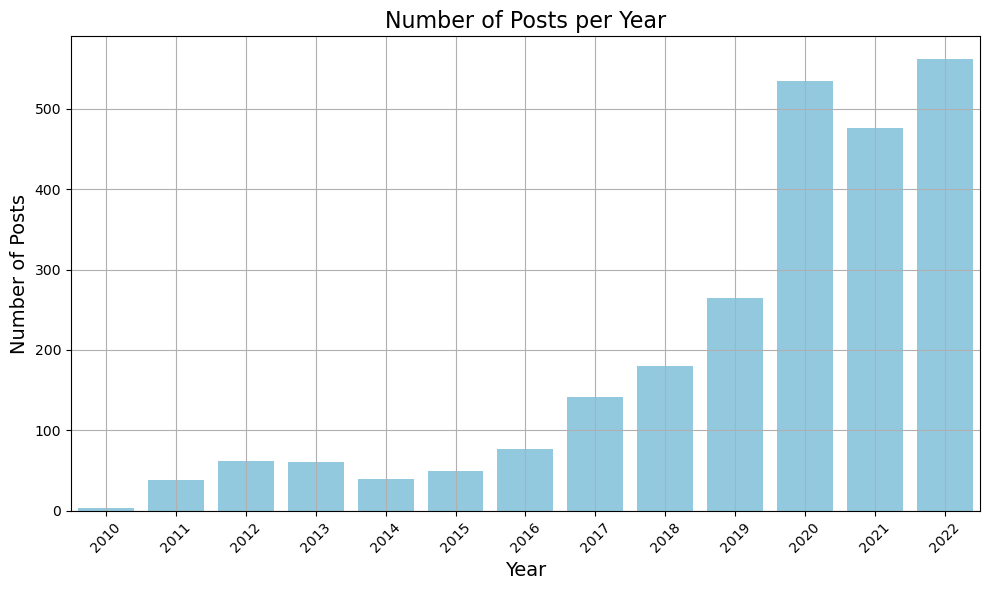

/Users/jakobkuemmerle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jakobkuemmerle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


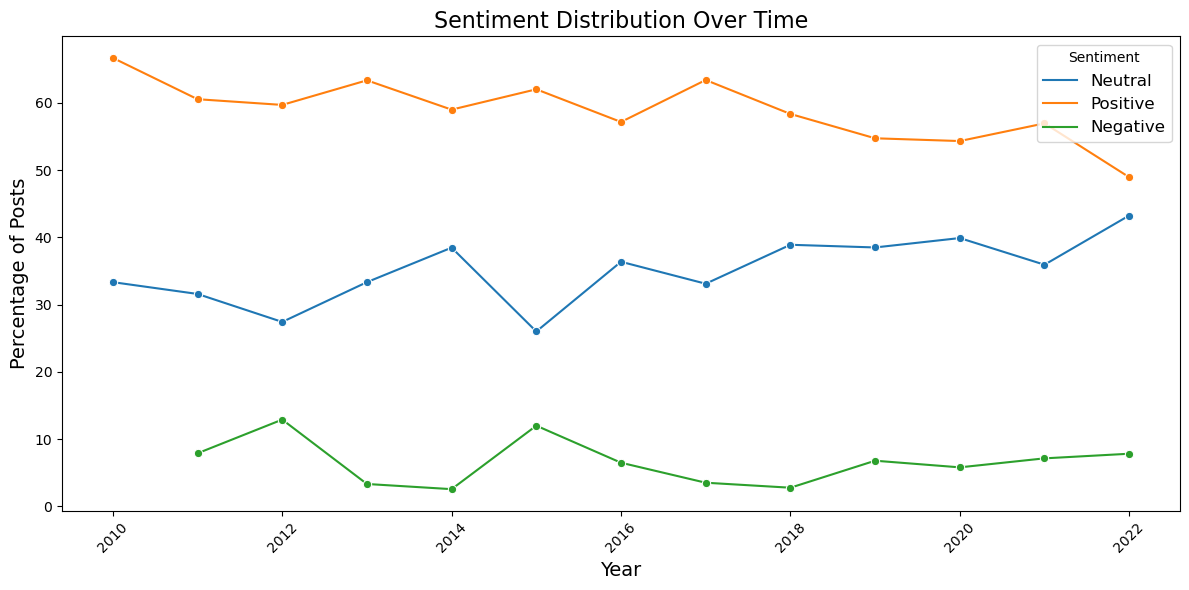

Identified Topics:
Topic 1: im, nu, northwestern, know, student, like, people, dont, campus, year
Topic 2: im, northwestern, like, nu, school, student, know, really, want, campus
Topic 3: im, student, nu, northwestern, class, course, major, program, like, year
Topic 4: school, northwestern, im, nu, major, like, want, know, class, year
Topic 5: student, aid, im, campus, northwestern, housing, nu, financial, evanston, looking

Cluster Descriptions:
Topic 1 - Top Words: im, nu, northwestern, know, student, like, people, dont, campus, year
Example 1: Hey /northwestern,
So I'm a sophomore, and three friends and I are looking to live off campus next year (so, probably 3-4 bedroom apt or a small house).  I know it's about that time to start looking, ...
Example 2: You probably got this email from the Dean of Students, but if you skipped over it...

Dear Students:

The City of Evanston today announced that, it does not plan to enforce more strictly a city ordina...
Example 3: Hey there fellow 

<Figure size 1200x600 with 0 Axes>

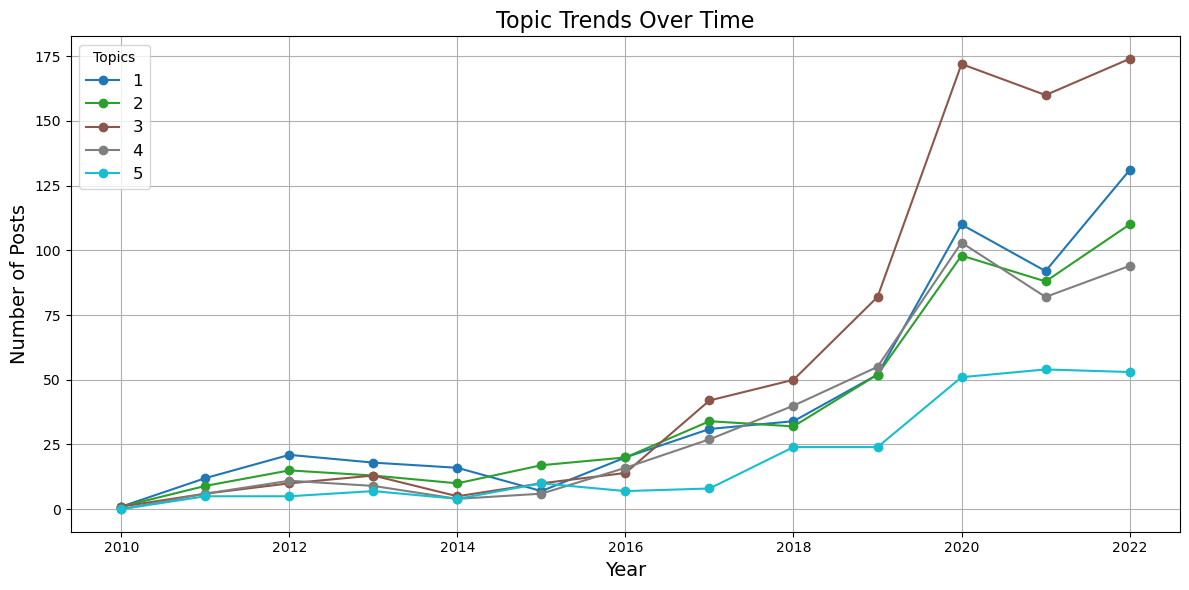

Detected Spikes in Topics:
dominant_topic         1   2         3         4         5
year                                                      
2010                 NaN NaN       NaN       NaN       NaN
2011                 NaN NaN       NaN       inf       inf
2012                 NaN NaN       NaN       NaN       NaN
2013                 NaN NaN       NaN       NaN       NaN
2014                 NaN NaN       NaN       NaN       NaN
2015                 NaN NaN  0.560000       NaN  0.950000
2016            0.855288 NaN       NaN  0.731602       NaN
2017                 NaN NaN  0.626761       NaN       NaN
2018                 NaN NaN       NaN       NaN  1.366667
2019                 NaN NaN       NaN       NaN       NaN
2020                 NaN NaN       NaN       NaN       NaN
2021                 NaN NaN       NaN       NaN       NaN
2022                 NaN NaN       NaN       NaN       NaN


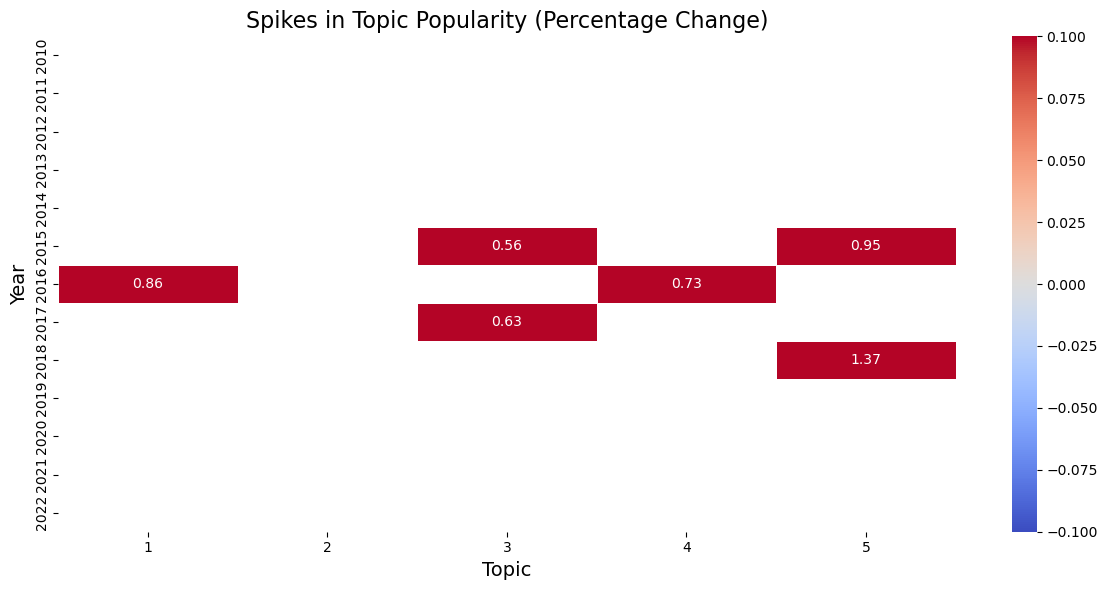

Trending Topic for 2020-09: Topic 0
Top words for Topic 0: student, aid, im, campus, northwestern, housing, nu, financial, evanston, looking


In [12]:
# Example usage of the pipeline
if __name__ == "__main__":
    file_path = '../downloads/reddit-downloads/Northwestern_submissions.zst'
    min_chars = 100
    keywords = ["northwestern", "NU"]
    start_year = 2000
    end_year = 2024
    
    result_df = analyze_reddit_data(file_path, min_chars, keywords, start_year, end_year)
    sentiment_results, sentiment_distribution = sentiment_analysis_pipeline(result_df)
    # Example usage
    topic_modeling_pipeline(result_df, n_topics=5, max_features=5000, n_top_words=10)
    trending_topic_pipeline(result_df, year=2020, month=9)

